In [1]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

##Лаб_3. RNN в обработке текстов.


### Задание 1.
Решите задачу расшифровки сообщения с помощью RNN. Представьте, что вам даны сообщения, зашифрованные с помощью шифра Цезаря, являющимся одним из самый простых шифров, в криптографии.
Шифр цезаря работает следующим образом: каждая буква исходного алфавита сдвигается на K символов вправо:
Пусть нам дано сообщение: message="RNN IS NOT AI", тогда наше шифрование выполняющиеся по правилу f, с K=2, даст нам результат: f(message, K) = TPPAKUAPQVACK.
Для удобства можно взять символы только одного регистра в нашей имплементации, и сказать, что все буквы не английского алфавита будут отмечены как прочерк "-"


In [ ]:
stride = 3
vocab = list('abcdefghijklmnopqrstuvwxyz 1234567890')
vocab.insert(0,'-')
char_idx = {char : idx for char, idx in enumerate(vocab)}
idx_char = {idx : char for char, idx in enumerate(vocab)}

def encrypt(input_text, stride = 3, char_idx=char_idx, idx_char=idx_char, vocab=vocab):

    input_text = [i if i in vocab else vocab[0] for i in input_text.lower()]
    encrypted = [vocab[(vocab.index(i) + stride) % len(vocab)] for i in input_text]

    x = [idx_char[char] for char in encrypted]
    y = [idx_char[char] for char in input_text]

    return torch.tensor(x), torch.tensor(y)

def generate_dataset(seq_len = 23, dataset_len = 512):
    x_dataset, y_dataset = [], []
    for i in range(dataset_len):
        message = ''.join([random.choice(vocab) for j in range(seq_len)])
        encrypted = encrypt(message)
        x_dataset.append(encrypted[0])
        y_dataset.append(encrypted[1])
    return [x_dataset, y_dataset]

seq_len = 23
# batch_size = 32
data = generate_dataset(dataset_len=2)
data

[[tensor([27, 14, 18, 35, 20, 18, 24, 21, 32,  7,  3, 29, 30, 33, 20, 35, 14, 35,
          20,  7, 15, 29, 30]),
  tensor([26, 15,  0, 21, 11, 27,  3,  0, 23, 27, 11, 36, 33,  9,  5, 14, 16, 18,
           4, 24, 14, 24, 12])],
 [tensor([24, 11, 15, 32, 17, 15, 21, 18, 29,  4,  0, 26, 27, 30, 17, 32, 11, 32,
          17,  4, 12, 26, 27]),
  tensor([23, 12, 35, 18,  8, 24,  0, 35, 20, 24,  8, 33, 30,  6,  2, 11, 13, 15,
           1, 21, 11, 21,  9])]]

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

# x_train, x_test, y_train, y_test = train_test_split(data[0], data[1], train_size=0.8, random_state=42)
# train_data = TensorDataset(x_train, y_train)
# test_data = TensorDataset(x_test, y_test)
# train_loader = DataLoader(train_data, batch_size=batch_size)
# test_loader = DataLoader(test_data, batch_size=batch_size)

In [ ]:
for x, y in data:
    print(x.shape, y.shape)
    break

torch.Size([23]) torch.Size([23])


In [ ]:
class Decipher(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, n_layers=1, batch_size=1):
        super(Decipher, self).__init__()
        self.embed = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=n_layers)

        self.fc = nn.Linear(hidden_dim, vocab_size)
        self.initial_hidden = torch.zeros(n_layers, batch_size, hidden_dim)

    def forward(self, cipher):
        # Unsqueeze 1 dimension for batches
        emb_x = self.embed(cipher).unsqueeze(1)
        out_rnn, hidden = self.rnn(emb_x, self.initial_hidden)
        # Apply the affine transform and transpose output in appropriate way
        # because you want to get the softmax on vocabulary dimension
        # in order to get probability of every letter
        out = self.fc(out_rnn)
        out = out.transpose(1, 2)
        return out


In [ ]:
embedding_dim = 5
hidden_dim = 10
vocab_size = len(vocab)
lr = 0.1

criterion = torch.nn.CrossEntropyLoss()
model = Decipher(vocab_size, embedding_dim, hidden_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=lr) #weight_decay=1e-4

num_epochs = 10

In [ ]:
for x in range(num_epochs):
    print('Epoch: {}'.format(x))
    for encrypted, original in data:
        scores = model(encrypted)
        original = original.unsqueeze(1)
        loss = criterion(scores, original)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print('Loss: {:6.4f}'.format(loss.item()))

    with torch.no_grad():
        matches, total = 0, 0
        for encrypted, original in data:
            # Compute a softmax over the outputs
            predictions = F.softmax(model(encrypted), 1)
            # Choose the character with the maximum probability (greedy decoding)
            _, batch_out = predictions.max(dim=1)
            # Remove batch
            batch_out = batch_out.squeeze(1)
            # Calculate accuracy
            matches += torch.eq(batch_out, original).sum().item()
            total += torch.numel(batch_out)
        accuracy = matches / total
        print('Accuracy: {:4.2f}%'.format(accuracy * 100))

Epoch: 0
Loss: 3.6715
Accuracy: 23.91%
Epoch: 1
Loss: 2.9908
Accuracy: 34.78%
Epoch: 2
Loss: 2.5115
Accuracy: 41.30%
Epoch: 3
Loss: 2.0251
Accuracy: 56.52%
Epoch: 4
Loss: 1.5949
Accuracy: 69.57%
Epoch: 5
Loss: 1.1714
Accuracy: 78.26%
Epoch: 6
Loss: 0.8972
Accuracy: 82.61%
Epoch: 7
Loss: 0.6918
Accuracy: 86.96%
Epoch: 8
Loss: 0.5319
Accuracy: 93.48%
Epoch: 9
Loss: 0.3967
Accuracy: 97.83%


### Задание 2.
Примените RNN к классификации текстов из лабораторной работы №1 (на несбалансированных и балансированных классах). Сравните результаты с классическими методами машинного обучения. Сделайте выводы!

####модель rnn

In [161]:
import torch.nn as nn

class RNNClassifier(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim,
                 n_layers=1, batch_size=16):
        super(RNNClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_size)
        self.hidden = torch.zeros(n_layers, hidden_dim) # 1 -> batch_size

    def forward(self, x):
        # print(x.shape) # [16, 200]
        # print(self.hidden.shape) #[n_layers, hidden_dim]
        out, hidden = self.rnn(x, self.hidden)
        out = out.contiguous().view(-1, self.hidden_dim) # possibly because of this
        out = torch.tanh(self.fc2(self.fc1(out)))

        return out, hidden


In [174]:
from tqdm.notebook import tqdm

def train(train_loader, num_epochs, model, optimizer, criterion):
    losses_avg = []

    for epoch in tqdm(range(num_epochs+1)):
        losses = []
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            y_pred, hidden = model(x_batch)

            curr_loss = criterion(y_pred, y_batch)
            losses.append(curr_loss.item())
            curr_loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        losses_avg.append(sum(losses) / len(losses))

        if epoch % 10 == 0:
            print(f'epoch : {epoch}, loss : {losses_avg[-1]}')

In [201]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

def test(test_loader, model):
    predicted = []
    true = []
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            y_pred, _ = model(x_batch)
            predicted.extend(torch.argmax(y_pred, axis=1).tolist())
            true.extend(y_batch.tolist())

    true = np.array(true)
    predicted = np.array(predicted)

    cr = classification_report(true, predicted)
    cm = confusion_matrix(true, predicted)
    print(cr)
    plt.figure(figsize=(5,3))
    sns_plot = sns.heatmap(cm, annot=True, fmt='d', cmap='pink')
    plt.show()

####классические модели (без разбиения на train и test)

In [204]:
def train_model(model, x, y):
    model.fit(x, y)

    y_pred = model.predict(x)
    print(f'модель : {model}')
    print(classification_report(y, y_pred))
    confusion_matrix(y, y_pred)
    plt.figure(figsize=(5,3))
    sns_plot = sns.heatmap(confusion_matrix(y, y_pred), annot=True, fmt='d')
    plt.show()

In [193]:
from sklearn import svm, neighbors, tree
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

svc = svm.SVC()
linearSVC = svm.LinearSVC()
gaussianSVC = svm.SVC(kernel='rbf')
polynomialSVC = svm.SVC(kernel='poly', degree=8)

nbrs = neighbors.KNeighborsClassifier(n_neighbors=2)
mlp = MLPClassifier(solver='lbfgs')
decision_tree = tree.DecisionTreeClassifier()
gnb = GaussianNB()

models = [svc, linearSVC, gaussianSVC, polynomialSVC, nbrs, mlp, decision_tree, gnb]

####сбалансированные классы (были таковыми изначально)

In [100]:
import pandas as pd

sample_positive = pd.read_json('/content/drive/MyDrive/Colab Notebooks/тексты/предыдущее/sample_positive.json')
sample_negative = pd.read_json('/content/drive/MyDrive/Colab Notebooks/тексты/предыдущее/sample_negative.json')

sample_positive['text'] = sample_positive['text'].str.lower()
sample_negative['text'] = sample_negative['text'].str.lower()
sample_positive['rating'] = 1
sample_negative['rating'] = 0

dataframe = pd.concat([sample_positive[['text', 'rating']], sample_negative[['text', 'rating']]], ignore_index=True)
dataframe = dataframe.drop(3436, axis=0).reset_index().drop('index', axis=1)

In [101]:
# классы были сбалансированы на этапе отбора данных
dataframe['rating'].value_counts()

1    2830
0    2377
Name: rating, dtype: int64

In [102]:
tokenized = [word_tokenize(text) for text in dataframe['text'].values.tolist()]
print(tokenized[:2])

[['важно', '!', 'у', 'кого', 'низкий', 'фпс', 'открываем', 'параметры', 'запуска', 'и', 'вписываем', ':', '``', '-window-mode', 'exclusive', "''", '(', 'в', 'начале', 'пробел', 'стоит', 'там', '!', ')', 'и', 'если', 'при', 'запуске', 'игра', 'в', 'окне', 'стала', ',', 'то', 'нажимаем', '``', 'alt', '+', 'enter', "''", '.', 'если', 'фпс', 'не', 'сильно', 'увеличился', ',', 'то', 'в', 'самой', 'игре', 'нажимаем', 'f5', 'и', 'прописываем', '``', 'lodbias', '#', "''", 'где', 'решетка', 'это', 'цифровое', 'значение', '(', '2', 'по', 'умолчанию', ')', '.', 'выставляем', '1', 'при', 'среднем', 'пк', ',', 'или', 'если', 'пк', 'старенький', 'то', '0.5', 'благодаря', 'этим', 'манипуляциям', 'игра', 'прибавила', '20-25', 'фпс', 'и', 'у', 'меня', 'теперь', 'стабильные', '50', 'фпс', '!', 'игра', 'не', 'обычная', ',', 'советую', 'купить', 'и', 'опробовать', ',', 'если', 'что', 'за', '2', 'часа', 'можно', 'ее', 'вернуть', 'обратно', '!'], ['луга', '-', 'пинаешь', 'живой', 'пень', '.', 'бегаешь', 'за

In [103]:
from gensim.models import Word2Vec

emb = Word2Vec(tokenized, vector_size=200, min_count=5, window=5).wv

In [104]:
len(emb)

6464

In [108]:
def review2vec(review, emb=emb, dim=200):
    review = word_tokenize(review)
    tokens_emb = []
    for token in review:
        try:
            tokens_emb.append(emb[token])
        except:
            continue
    if len(tokens_emb):
        return sum(tokens_emb) / len(tokens_emb)
    else:
        return [0] * dim

In [109]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [110]:
from torch.utils.data import DataLoader, TensorDataset

x = torch.tensor([review2vec(review) for review in dataframe['text']])
y = torch.tensor([rating for rating in dataframe['rating']])

dataset = TensorDataset(x, y)
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size

batch_size = 16

train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_set, batch_size, drop_last=True)
test_loader = DataLoader(test_set, batch_size, drop_last=True)

<ipython-input-110-0ea797de9617>:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  x = torch.tensor([review2vec(review) for review in dataframe['text']])


In [190]:
from torch.optim import Adam

lr = 0.001
num_epochs = 100

rnn = RNNClassifier(x.shape[1], 2, hidden_dim=32, n_layers=1)
nn.init.xavier_normal_(rnn.fc1.weight)
nn.init.xavier_normal_(rnn.fc2.weight)
rnn.to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = Adam(rnn.parameters(), lr=lr)

train(train_loader, num_epochs, rnn, optimizer, criterion)

  0%|          | 0/101 [00:00<?, ?it/s]

epoch : 0, loss : 0.6879385132056016
epoch : 10, loss : 0.6578641379108796
epoch : 20, loss : 0.6313050601344842
epoch : 30, loss : 0.5981500990115679
epoch : 40, loss : 0.5826081184240488
epoch : 50, loss : 0.5696852202598865
epoch : 60, loss : 0.5501426678437453
epoch : 70, loss : 0.5240770736565956
epoch : 80, loss : 0.5237886824286901
epoch : 90, loss : 0.521389579314452
epoch : 100, loss : 0.5153032545859997


              precision    recall  f1-score   support

           0       0.55      0.31      0.40       470
           1       0.58      0.79      0.67       570

    accuracy                           0.57      1040
   macro avg       0.57      0.55      0.53      1040
weighted avg       0.57      0.57      0.55      1040



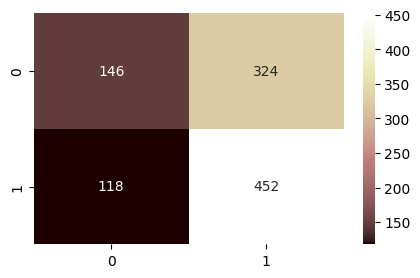

In [202]:
test(test_loader, rnn)

модель : SVC()
              precision    recall  f1-score   support

           0       0.69      0.21      0.32      2377
           1       0.58      0.92      0.71      2830

    accuracy                           0.59      5207
   macro avg       0.63      0.56      0.52      5207
weighted avg       0.63      0.59      0.53      5207



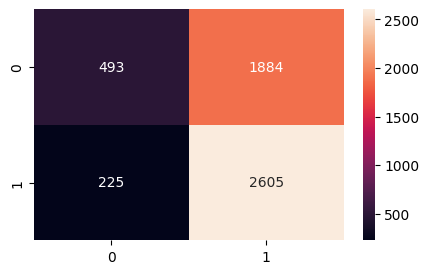

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


модель : LinearSVC()
              precision    recall  f1-score   support

           0       0.64      0.42      0.51      2377
           1       0.62      0.81      0.70      2830

    accuracy                           0.63      5207
   macro avg       0.63      0.61      0.61      5207
weighted avg       0.63      0.63      0.61      5207



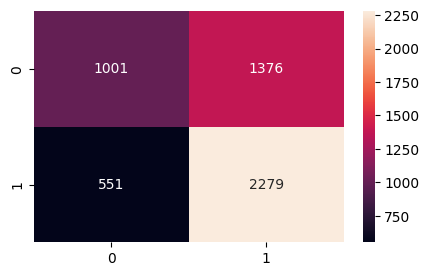

модель : SVC()
              precision    recall  f1-score   support

           0       0.69      0.21      0.32      2377
           1       0.58      0.92      0.71      2830

    accuracy                           0.59      5207
   macro avg       0.63      0.56      0.52      5207
weighted avg       0.63      0.59      0.53      5207



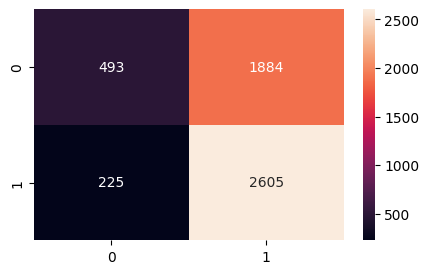

модель : SVC(degree=8, kernel='poly')
              precision    recall  f1-score   support

           0       0.82      0.17      0.28      2377
           1       0.58      0.97      0.73      2830

    accuracy                           0.60      5207
   macro avg       0.70      0.57      0.51      5207
weighted avg       0.69      0.60      0.52      5207



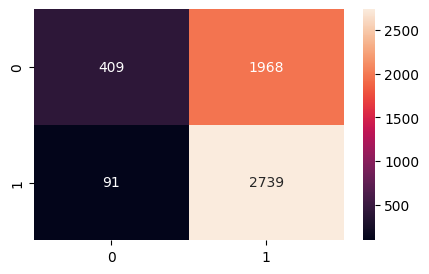

модель : KNeighborsClassifier(n_neighbors=2)
              precision    recall  f1-score   support

           0       0.70      0.95      0.80      2377
           1       0.94      0.65      0.77      2830

    accuracy                           0.79      5207
   macro avg       0.82      0.80      0.79      5207
weighted avg       0.83      0.79      0.79      5207



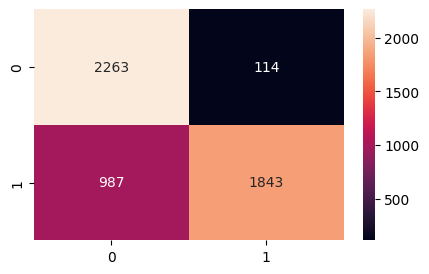

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


модель : MLPClassifier(solver='lbfgs')
              precision    recall  f1-score   support

           0       0.70      0.65      0.67      2377
           1       0.72      0.77      0.74      2830

    accuracy                           0.71      5207
   macro avg       0.71      0.71      0.71      5207
weighted avg       0.71      0.71      0.71      5207



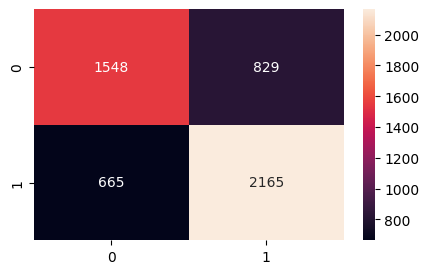

модель : DecisionTreeClassifier()
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      2377
           1       0.97      0.99      0.98      2830

    accuracy                           0.98      5207
   macro avg       0.98      0.98      0.98      5207
weighted avg       0.98      0.98      0.98      5207



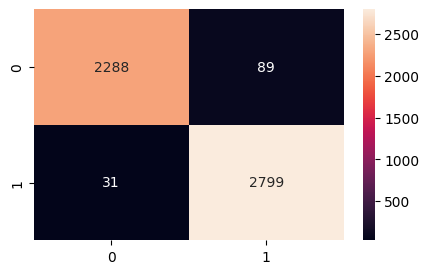

модель : GaussianNB()
              precision    recall  f1-score   support

           0       0.48      0.81      0.60      2377
           1       0.62      0.26      0.37      2830

    accuracy                           0.51      5207
   macro avg       0.55      0.54      0.49      5207
weighted avg       0.56      0.51      0.48      5207



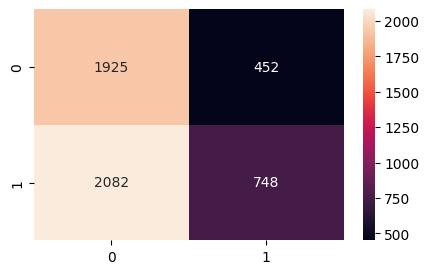

In [205]:
for model in models:
    train_model(model, x, y)

####несбалансированные классы

In [182]:
dataframe1 = pd.concat([sample_positive[['text', 'rating']].sample(800), dataframe], ignore_index=True)
dataframe1['rating'].value_counts()

1    3630
0    2377
Name: rating, dtype: int64

In [183]:
x1 = torch.tensor([review2vec(review) for review in dataframe1['text']])
y1 = torch.tensor([rating for rating in dataframe1['rating']])

dataset1 = TensorDataset(x1, y1)
train_size1 = int(len(dataset1) * 0.8)
test_size1 = len(dataset1) - train_size1

batch_size = 16

train_set1, test_set1 = torch.utils.data.random_split(dataset1, [train_size1, test_size1])

train_loader1 = DataLoader(train_set1, batch_size, drop_last=True)
test_loader1 = DataLoader(test_set1, batch_size, drop_last=True)

In [187]:
from torch.optim import Adam

lr = 0.001
num_epochs = 100

rnn1 = RNNClassifier(x1.shape[1], 2, hidden_dim=32, n_layers=1)
nn.init.xavier_normal_(rnn1.fc1.weight)
nn.init.xavier_normal_(rnn1.fc2.weight)
rnn1.to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = Adam(rnn1.parameters(), lr=lr)

train(train_loader1, num_epochs, rnn1, optimizer, criterion)

  0%|          | 0/101 [00:00<?, ?it/s]

epoch : 0, loss : 0.6751717887322108
epoch : 10, loss : 0.6398737087845803
epoch : 20, loss : 0.61640831609567
epoch : 30, loss : 0.5909857408205668
epoch : 40, loss : 0.571275453766187
epoch : 50, loss : 0.5542617374658585
epoch : 60, loss : 0.5424736118316651
epoch : 70, loss : 0.5375585813323657
epoch : 80, loss : 0.526732514500618
epoch : 90, loss : 0.5252744440237681
epoch : 100, loss : 0.5368949539462725


              precision    recall  f1-score   support

           0       0.50      0.34      0.41       486
           1       0.63      0.77      0.69       714

    accuracy                           0.60      1200
   macro avg       0.57      0.56      0.55      1200
weighted avg       0.58      0.60      0.58      1200



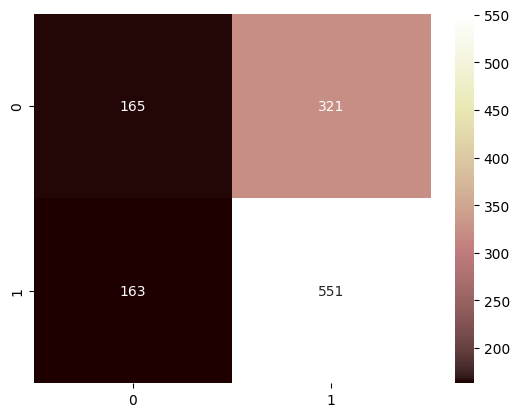

In [188]:
test(test_loader1, rnn1)

модель : SVC()
              precision    recall  f1-score   support

           0       0.88      0.04      0.08      2377
           1       0.61      1.00      0.76      3630

    accuracy                           0.62      6007
   macro avg       0.75      0.52      0.42      6007
weighted avg       0.72      0.62      0.49      6007



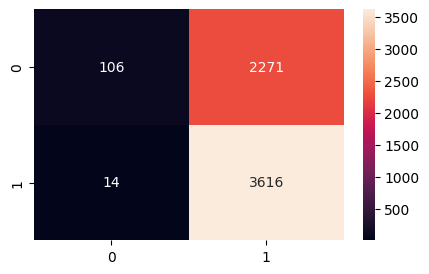

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


модель : LinearSVC()
              precision    recall  f1-score   support

           0       0.67      0.19      0.29      2377
           1       0.64      0.94      0.76      3630

    accuracy                           0.64      6007
   macro avg       0.65      0.56      0.53      6007
weighted avg       0.65      0.64      0.57      6007



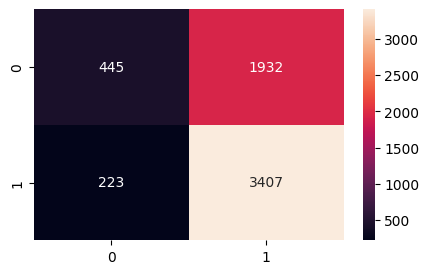

модель : SVC()
              precision    recall  f1-score   support

           0       0.88      0.04      0.08      2377
           1       0.61      1.00      0.76      3630

    accuracy                           0.62      6007
   macro avg       0.75      0.52      0.42      6007
weighted avg       0.72      0.62      0.49      6007



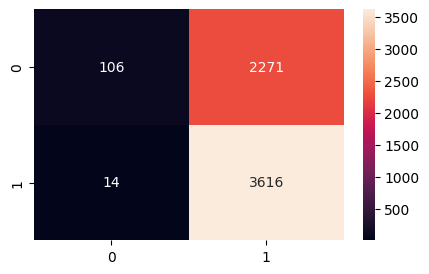

модель : SVC(degree=8, kernel='poly')
              precision    recall  f1-score   support

           0       0.90      0.11      0.20      2377
           1       0.63      0.99      0.77      3630

    accuracy                           0.64      6007
   macro avg       0.77      0.55      0.49      6007
weighted avg       0.74      0.64      0.54      6007



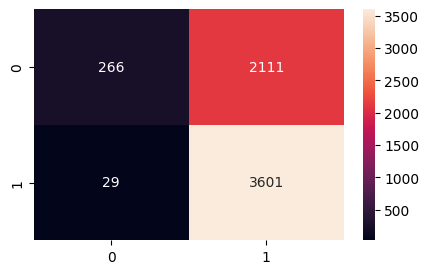

модель : KNeighborsClassifier(n_neighbors=2)
              precision    recall  f1-score   support

           0       0.76      0.95      0.85      2377
           1       0.96      0.81      0.88      3630

    accuracy                           0.86      6007
   macro avg       0.86      0.88      0.86      6007
weighted avg       0.88      0.86      0.86      6007



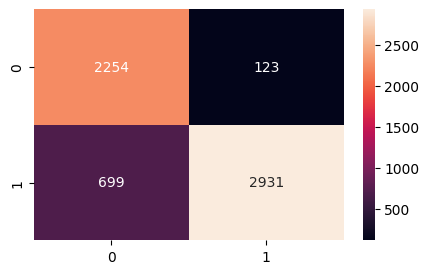

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


модель : MLPClassifier(solver='lbfgs')
              precision    recall  f1-score   support

           0       0.69      0.55      0.61      2377
           1       0.74      0.84      0.79      3630

    accuracy                           0.72      6007
   macro avg       0.71      0.69      0.70      6007
weighted avg       0.72      0.72      0.72      6007



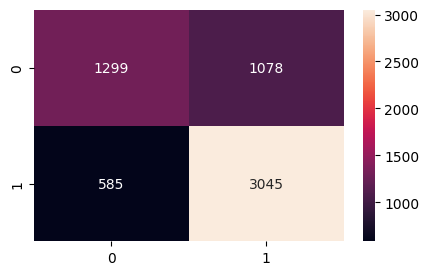

модель : DecisionTreeClassifier()
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      2377
           1       0.97      0.99      0.98      3630

    accuracy                           0.98      6007
   macro avg       0.98      0.98      0.98      6007
weighted avg       0.98      0.98      0.98      6007



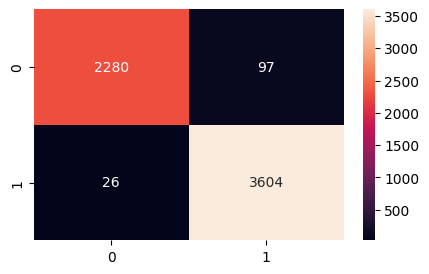

модель : GaussianNB()
              precision    recall  f1-score   support

           0       0.42      0.81      0.55      2377
           1       0.68      0.27      0.38      3630

    accuracy                           0.48      6007
   macro avg       0.55      0.54      0.47      6007
weighted avg       0.58      0.48      0.45      6007



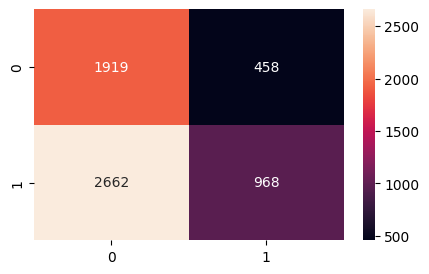

In [206]:
for model in models:
    train_model(model, x1, y1)

### Задание 3.
Для корпуса собраний сочинений Федора Михайловича Достоевского сделайте следующие задания:
Сколько слов и предложений в датасете?
Каковы частоты для слов «бесы», «семья», «брат». Выведите значение, округленное до 5 знаков.
~Сгенерируйте текст, который состоит из слов с вероятностями появления от 0. 85 до 0.95 и итоговое предложение состоит из 10 слов.~


In [52]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

from nltk import word_tokenize, sent_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import re

data = open(r'/content/drive/MyDrive/Colab Notebooks/тексты/dostoevsky.txt', 'r').read()
data = re.sub('[^\S]', ' ', data)
data = data[1:].lower()

In [8]:
sents = sent_tokenize(data)
words = word_tokenize(data)
print(f'слов: {len(words)}, \nпредложений: {len(sents)}')

слов: 2305463, 
предложений: 123527


In [4]:
fdist = FreqDist(words)
fdist

FreqDist({',': 265751, '.': 85088, 'и': 84566, '—': 53930, 'не': 41744, 'в': 41560, 'что': 36049, 'я': 34307, '!': 22568, 'на': 21729, ...})

In [32]:
for word in ['бес', 'бесы', 'семья', 'брат']:
    print(f'{word} : {fdist.get(word)}')

бес : 10
бесы : 15
семья : 22
брат : 552


In [33]:
for word in ['бес', 'бесы', 'семья', 'брат']:
    print(f'{word} : {round(fdist.get(word) / fdist.N(), 5)}')

бес : 0.0
бесы : 1e-05
семья : 1e-05
брат : 0.00024


In [9]:
# pip install pymorphy3
import pymorphy3

In [70]:
morph = pymorphy3.MorphAnalyzer()
stops = stopwords.words('russian')
stops.extend(['это', 'свой'])

new_words = [morph.parse(word)[0].normal_form for word in words]
new_words = [word for word in new_words if word not in stops]

freqs = FreqDist(new_words)

In [71]:
freqs.N(), freqs.B()

(1462796, 43643)

In [72]:
for word in ['бес', 'семья', 'брат']:
    print(f'{word} : {freqs.get(word)}')

бес : 30
семья : 122
брат : 973


In [73]:
for word in ['бес', 'семья', 'брат']:
    print(f'{word} : {round(freqs.get(word) / freqs.N(), 5)}')

бес : 2e-05
семья : 8e-05
брат : 0.00067


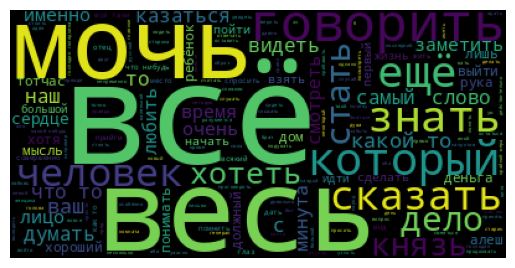

In [74]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

text = ' '.join(new_words)
wordcloud = WordCloud().generate(text)

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Задание 4.
На основе минимум 2 коллекций предобученных эмбеддингов для русского языка постройте эмбеддинги для корпуса собраний сочинений Федора Михайловича Достоевского. Сделайте экспертную оценку построенной модели на примерах (униграммы и биграммы).
Примеры коллекций: https://natasha.github.io/navec/; https://rusvectores.org/ru/models/)

Сделайте визуализацию.

In [208]:
# pip install navec
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from bokeh.io import output_notebook
from navec import Navec

import random
import bokeh.models as bm, bokeh.plotting as pl

In [215]:
sample = random.sample(list(set(new_words)), 1000)
navec_hudlit = Navec.load('/content/drive/MyDrive/Colab Notebooks/тексты/navec_hudlit_v1_12B_500K_300d_100q.tar')
navec_news = Navec.load('/content/drive/MyDrive/Colab Notebooks/тексты/navec_news_v1_1B_250K_300d_100q.tar')

In [211]:
def get_vectors(model, words):
    word_vectors = [model.get(word) if word in model else np.zeros((300,)) for word in words]

    pca = PCA(n_components=2)
    pca.fit(word_vectors)
    word_vectors_pca = pca.transform(word_vectors)

    ss = StandardScaler().fit(word_vectors_pca)
    word_vectors_pca = ss.transform(word_vectors_pca)

    return word_vectors_pca[:, 0], word_vectors_pca[:, 1]

In [212]:
def draw_vectors(x, y, radius=10, alpha=0.25, color='blue',
                 width=600, height=400, show=True, **kwargs):
    if isinstance(color, type('str')): color = [color] * len(x)
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, **kwargs })

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show: pl.show(fig)
    return fig

In [216]:
output_notebook()

x, y = get_vectors(navec_hudlit, sample)

draw_vectors(x, y, token=sample)

figure(id='p1102', ...)

In [217]:
output_notebook()

x, y = get_vectors(navec_news, sample)

draw_vectors(x, y, token=sample)

figure(id='p1151', ...)

###Выводы

В сравнении с классическими методами машинного обучения RNN-модель на задаче бинарной классификации показала не лучшие результаты. Модель из 3-х RNN-слоёв прекращала учиться после 10 из 100 эпох и на тестовых данных предсказывала только один класс независимо от сбалансированности классов. Лучше себя показала модель из 1-го RNN-слоя: accuracy 0.57. На данной задаче классические методы машинного обучения оказались намного быстрее и эффективние (KNeighborsClassifier(n_neighbors=2) показал accuracy 0.79). Вероятно проблема в предварительной обработке данных.